# **Data Exploration**

### **Student Identification**

Student Name       | Student Email
-------------------|------------------
Daniel Branco      | r20191230@novaims.unl.pt
Filipe Dias        | r20181050@novaims.unl.pt
Gonçalo Lourenço   | r20191097@novaims.unl.pt
Inês Santos        | r20191184@novaims.unl.pt
Manuel Marreiros   | r20191223@novaims.unl.pt

### **Data Source**

Brain Tumor Classification (MRI) Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

Drive with data: https://drive.google.com/file/d/1P3hcUss5Kqb28_WQUcTsuTW2VjNTX4pd/view?usp=share_link

### **Introduction**

Brain tumors are one of the top causes of cancer-related fatalities globally and, as such, it is vital to be able to identify such tumors as quickly and efficiently as possible. 

In that sense, it is known that Deep Learning methods have demonstrated great promise in the study of medical images and have been effectively used for a number of tasks, including the detection of brain tumors in MRI scans. 

The goal of this project is to apply the knowledge acquired during the Deep Learning course in order to create a model that can recognize various brain tumor kinds from MRI images. After being trained on a sizable collection of annotated MRI scans, the algorithm will categorize the images into one of these four classes:

1. No Tumor (no abnormal growth of cells in the brain)
2. Benign Tumor (non-cancerous and usually grows slowly)
3. Malignant Tumor (cancerous and grows quickly. It can invade nearby tissue and spread to other parts of the brain or body)
4. Pituitary Tumor (develops in the pituitary gland, which is located at the base of the brain. Most pituitary tumors are benign and slow-growing)

Throughout the project, several steps will be taken to solve this supervised machine learning problem, including data exploration and preprocessing, model building, model training and evaluation, hyper parameterization and more. Hopefully, once all these steps are applied, we will end up with a model that can classify unseen tumor images at a decent level.

### **Notebook Summary**





In this notebook, we proceed to do the initial exploration of our dataset. 

We started by downloading the data and taking a first look at it. Then, we inspected classes' balance with the aid of a bar chart and reach the conclusion that one class had significantly less instances than the other three. This issue will be solved by creating custom class weights in the preprocessing stage and applying them once we fit the data to our models.

Once that was done, we defined some parameters that we wanted all images to have, like the size (128, 128) or the color_mode, which we switched from 'rgb' to 'grayscale' after realizing our pictures had no color besides black and white (as a pixel intensity graph showed) and concluding that the models performed better in the absence of color. At this point, we also split our data into training and validation (80/20 split) and created batches of 64 instances each to later train the models.

To finalize this step, we wanted to make sure everything was correct and so we just looked at a sample batch, confirming the images had all the right properties.





### **Imports**


In [ ]:
pip install keras-tuner tensorflow-addons --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 20.4 MB/s eta 0:00:00


In [ ]:
import os
import time
import math
import random 
import zipfile
import shutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 
from tensorflow.keras.initializers import GlorotNormal
import tensorflow_addons as tfa

import keras
from keras_tuner import Objective
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

### **Downloading the Data**

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Deep Learning/Projeto/"
main_folder, training_folder, testing_folder = "brain_tumor_data/", "Training/", "Testing/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'brain_tumor_data.zip', 'brain_tumor_data.zip')
    # Extract files
    zip_ = zipfile.ZipFile('brain_tumor_data.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 3.138 seconds


Taking a first look at the original images.

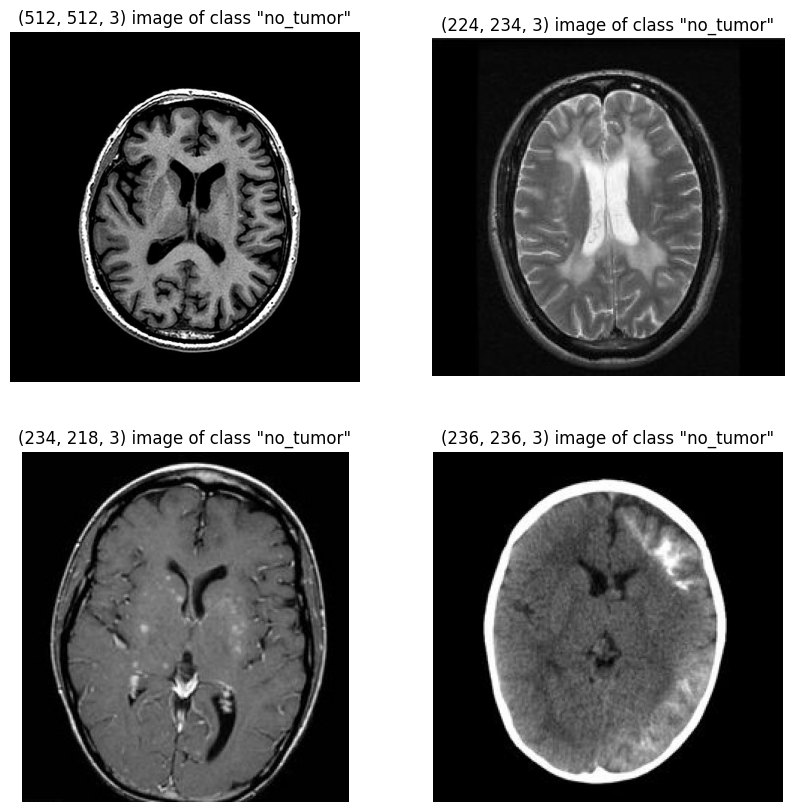

In [ ]:
def show_sample_images(folder_directory, class_):
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_))
        plt.axis("off")

show_sample_images(path + main_folder + training_folder, "no_tumor") #looking at pictures where a tumor is not present

We can easily undestand that pictures have different sizes and that is something that will be taken care of later in this project.

### **Inspecting Classes' Balance**

In [ ]:
classes = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]
for split in [training_folder, testing_folder]:
    for c in classes:
        n_train_c = len(os.listdir(path + main_folder + split + f"/{c}"))
        print(f"Nº of instances of class {c} in the {split}: {n_train_c}")

Nº of instances of class no_tumor in the Training/: 395
Nº of instances of class glioma_tumor in the Training/: 826
Nº of instances of class meningioma_tumor in the Training/: 822
Nº of instances of class pituitary_tumor in the Training/: 827
Nº of instances of class no_tumor in the Testing/: 105
Nº of instances of class glioma_tumor in the Testing/: 100
Nº of instances of class meningioma_tumor in the Testing/: 115
Nº of instances of class pituitary_tumor in the Testing/: 74


To better visualize this difference, let's plot the number of instances in each of the training classes to a bar chart.

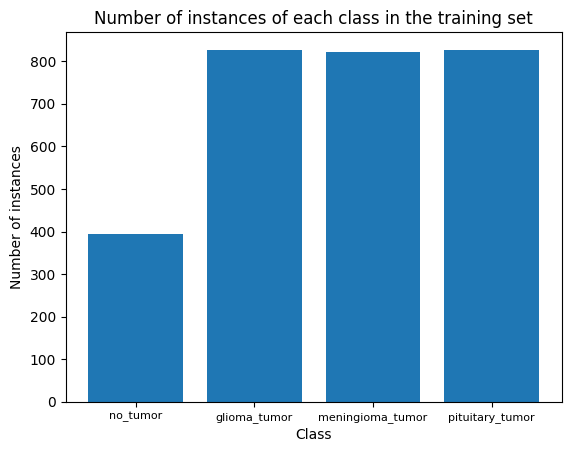

In [ ]:
# Create empty lists to store the number of instances and class names
n_train = []
class_names = []

# Loop through each class in the dataset
for c in classes:
    # Get the number of instances in the training set for the current class
    n_train_c = len(os.listdir(path + main_folder + training_folder + f"/{c}"))
    # Append the number of instances and class name to their respective lists
    n_train.append(n_train_c)
    class_names.append(c)

# Create a bar chart of the number of instances for each class in the training set
plt.bar(class_names, n_train)
plt.title("Number of instances of each class in the training set")
plt.xlabel("Class")
plt.xticks(fontsize=8)
plt.ylabel("Number of instances")
plt.show()

We can conclude that the class no_tumor has significantly fewer examples than the others. This can lead to a biased model that performs poorly on the minority class. One way to address this issue is by creating class weights that adjust the importance of each class during training, which is what we did in the preprocessing phase.

### **Creating Batches**

Here we start by defining a list of parameters for the ``image_dataset_from_directory``. Since our images have no color, we will change the original color_mode from rgb to gray scale. We tested our models with both color modes, and gray seems to be producing the best results. We will also reserve 20% of our images for  validation.

In [ ]:
image_size=(128, 128)
crop_to_aspect_ratio=True
color_mode='grayscale'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Using 574 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Let's now create batches of our images that we will later use to train the models.

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next() #batch_x_train variable stores the input data samples, and batch_y_train variable stores their corresponding labels.
print(batch_x_train.shape, batch_y_train.shape) #y_train.shape is (64, 4) because we are using batches of 64 images and we have 4 classes
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Y_train:")
print("Sample average of y_train:", tf.reduce_mean(batch_y_train)) #calculate the mean of the y_train
print("Sample variance of y_train:", tf.math.reduce_variance(batch_y_train)) #calculate the variance of the y_train
print("X_train:")
print("Sample average of X_train:", tf.reduce_mean(batch_x_train)) #calculate the mean of the X_train
print("Sample variance of X_train:", tf.math.reduce_variance(batch_x_train)) #calculate the variance of the X_train

(64, 128, 128, 1) (64, 4)

Sample of x_train: tf.Tensor(
[[0. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]], shape=(5, 4), dtype=float32)
Y_train:
Sample average of y_train: tf.Tensor(0.25, shape=(), dtype=float32)
Sample variance of y_train: tf.Tensor(0.1875, shape=(), dtype=float32)
X_train:
Sample average of X_train: tf.Tensor(46.077652, shape=(), dtype=float32)
Sample variance of X_train: tf.Tensor(2616.9468, shape=(), dtype=float32)


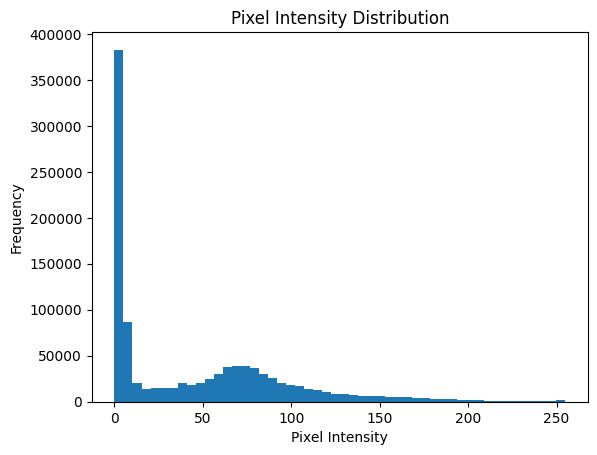

In [ ]:
# Flatten the batch_x_train tensor to a 1D array
flat_x_train = tf.reshape(batch_x_train, [-1])

# Plot the histogram
plt.hist(flat_x_train.numpy().flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

In this graph, Pixel Intensity represents the brightness level of each pixel in the image. The histogram shows the distribution of the pixel intensity values across all the images in the batch_x_train tensor. The x-axis represents the range of possible pixel intensity values, and the y-axis represents the frequency or count of pixels in the image that have a specific intensity value.

0 represents pixels with no intensity (meaning that they are black), and therefore the frequency is very high for this value. It is easy to understand that the dataset images are mostly black, thereforme this results were expected.

Let's now plot some images that belong to a specific batch.

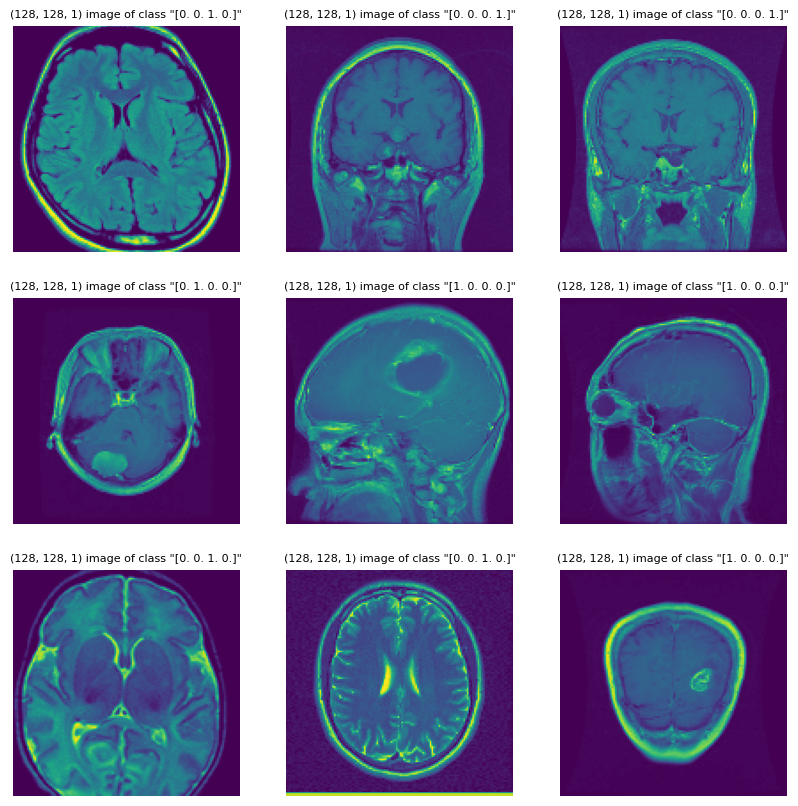

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

Let's now load the testing data using the ``image_dataset_from_directory()`` function.

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 394 files belonging to 4 classes.


We will have 394 instances to test our models on unseen data.